<a href="https://colab.research.google.com/github/KD08GG/IA/blob/main/FC2_Reinforcement_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Implementación del Entorno del Almacén

In [3]:
def random_obstacle() :
  import random
  x = random.randint(0, 9)
  #print(x)
  y = random.randint(0, 9)
  #print(y)
  if (x == 2 and y == 2 )or (x == 8 and y == 8) or (x==3 and y==3) or (x==5 and y==5) or (x== 1 and y== 1):
    random_obstacle()
  else:
    return (x,y)

In [4]:
import gym
import numpy as np
from gym import spaces

class WarehouseEnv(gym.Env):
    def __init__(self, grid_size=10):
        super(WarehouseEnv, self).__init__()
        self.delivered_packages = 0  # Contador de paquetes entregados


        # Tamaño de la cuadrícula
        self.grid_size = grid_size

        #Random obstacle
        x_r, y_r = random_obstacle()
        print("Random obstacle generated at [", x_r,",", y_r, "]")

        # Configuración del almacén
        self.obstacles = {(3, 3), (5,5), (x_r,y_r)}
        self.pickup_point = (9, 4)
        self.delivery_point = (8, 8)

        # Espacios de acción y observación
        self.action_space = spaces.Discrete(6)  # 0-3 (mover), 4 (recoger), 5 (entregar)
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0, 0]),
            high=np.array([grid_size - 1, grid_size - 1, 1, 100]),
            dtype=np.int32
        )

        # Estado inicial
        self.reset()

    def reset(self):
        """Reinicia el entorno y devuelve el estado inicial."""
        self.robot_pos = [1, 1]  # Posición inicial del robot
        self.has_item = 0        # Estado del ítem (0 = no tiene, 1 = tiene)
        self.energy = 100         # Energía inicial
        #x_r, y_r = random_obstacle()
        #print("Reset Random obstacle generated at [", x_r,",", y_r, "]")
        return np.array(self.robot_pos + [self.has_item, self.energy])

    def step(self, action):
        """Ejecuta una acción y devuelve (estado, recompensa, done, info)."""

        # Si la energía está en 0, termina el episodio automáticamente
        if self.energy == 0:
            return np.array(self.robot_pos + [self.has_item, self.energy]), -5, True, {}

        # Inicializar recompensa y done
        reward = -1  # Penalización base por movimiento
        done = False

        # Guardar posición previa
        prev_pos = self.robot_pos.copy()

        # Desglosar la acción
        if action in {0, 1, 2, 3}:  # Acciones de movimiento
            self.move(action)

        # Si el robot choca con un obstáculo, no se mueve y recibe penalización
        if tuple(self.robot_pos) in self.obstacles:
            self.robot_pos = prev_pos  # Regresa a la posición anterior
            reward = -10  # Penalización por colisión

        elif action == 4:  # Recoger ítem
            if tuple(self.robot_pos) == self.pickup_point and self.has_item == 0:
                self.has_item = 1
                #reward = 5  # Bonificación por recoger

        elif action == 5:  # Entregar ítem
            if tuple(self.robot_pos) == self.delivery_point and self.has_item == 1:
                reward = 10
                self.has_item = 0  # Suelta el paquete, pero sigue jugando
                self.delivered_packages += 1  # Incrementar el contador

        # Reducir energía solo si no ha terminado el episodio
        self.energy -= 1
        if self.energy == 0:  # Si la energía llega a 0, termina el episodio
            reward = -5
            done = True

        # Retornar estado, recompensa, done, info
        return np.array(self.robot_pos + [self.has_item, self.energy]), reward, done, {}

    def move(self, action):
        """Mueve al robot en la dirección dada (0 = arriba, 1 = abajo, 2 = izquierda, 3 = derecha)."""
        x, y = self.robot_pos

        if action == 0:  # Arriba
            y = max(0, y - 1)
        elif action == 1:  # Abajo
            y = min(self.grid_size - 1, y + 1)
        elif action == 2:  # Izquierda
            x = max(0, x - 1)
        elif action == 3:  # Derecha
            x = min(self.grid_size - 1, x + 1)

        self.robot_pos = [x, y]  # Mueve al robot



## Implementación del Agente de Aprendizaje por Refuerzo

In [5]:
import random
import numpy as np
from collections import defaultdict

class QLearningAgent:
    def __init__(self, env, alpha=0.99, gamma=0.8, epsilon=1.0, epsilon_decay=0.98, epsilon_min=0.01):
        self.env = env
        self.q_table = defaultdict(lambda: np.zeros(env.action_space.n))
        self.alpha = alpha  # Tasa de aprendizaje
        self.gamma = gamma  # Factor de descuento
        self.epsilon = epsilon  # Probabilidad inicial de exploración
        self.epsilon_decay = epsilon_decay  # Factor de reducción de exploración
        self.epsilon_min = epsilon_min  # Valor mínimo de epsilon

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()  # Exploración
        else:
            return np.argmax(self.q_table[tuple(state)])  # Explotación

    def update_q_table(self, state, action, reward, next_state):
        old_value = self.q_table[tuple(state)][action]
        next_max = np.max(self.q_table[tuple(next_state)])
        new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max)
        self.q_table[tuple(state)][action] = new_value

    def update_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)



## Entrenamiento del Agente

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time

def render(self, ax, img):
    """Renderiza la cuadrícula y actualiza en tiempo real."""
    grid = np.zeros((self.grid_size, self.grid_size))  # Matriz vacía

    for obs in self.obstacles:
        grid[obs] = 1  # Obstáculos
    grid[self.pickup_point] = 2  # Punto de recogida
    grid[self.delivery_point] = 3  # Punto de entrega

    x, y = self.robot_pos
    grid[y, x] = 4 if self.has_item else 5  # Robot (con o sin paquete)

    img.set_data(grid)  # 🔥 Actualiza la cuadrícula sin crear una nueva
    plt.draw()
    plt.pause(0.3)  # Pequeña pausa para que se note el movimiento


In [7]:
env = WarehouseEnv()
agent = QLearningAgent(env)

episodes = 10000
rewards_per_episode = []
entregas_historial = []
trayectoria_ultimo_ep = [(1, 1)]  # Aquí guardaremos la trayectoria del último episodio

for episode in range(episodes):
    state = env.reset()
    total_reward = 100  # Esto depende de tu configuración
    done = False
    env.delivered_packages = 0  # Reiniciar el contador de paquetes
    trayectoria_actual = [(1, 1)]  # Guardar trayectoria del episodio actual
    #trayectoria_ultimo_ep = [(1, 1)]

    while not done:
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)

        # Guardar la posición actual del robot
        trayectoria_actual.append(tuple(env.robot_pos))

        agent.update_q_table(state, action, reward, next_state)
        state = next_state
        total_reward += reward
        agent.update_epsilon()

    # Guardar la trayectoria del último episodio
    if episode == episodes - 1:
        trayectoria_ultimo_ep = trayectoria_actual

    entregas_historial.append(env.delivered_packages)
    rewards_per_episode.append(total_reward)

# Guardar la trayectoria dentro del objeto `env`
env.trayectoria_ultimo_ep = trayectoria_ultimo_ep

print("Entrenamiento completado.")


Random obstacle generated at [ 7 , 5 ]
Entrenamiento completado.


## Evaluación y Comparación con un Algoritmo Heurístico

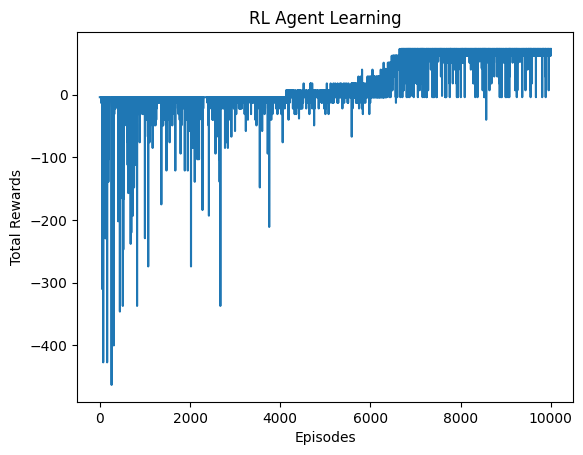

In [8]:
import matplotlib.pyplot as plt

plt.plot(rewards_per_episode)
plt.xlabel("Episodes")
plt.ylabel("Total Rewards")
plt.title("RL Agent Learning")
plt.show()


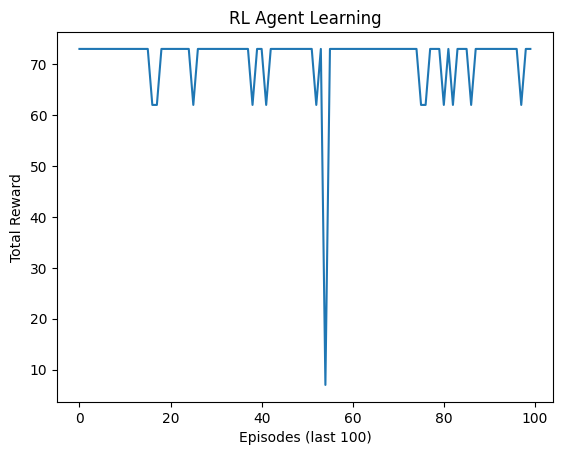

In [9]:
import matplotlib.pyplot as plt

# Asumiendo que tienes una lista 'rewards_per_episode' con recompensas de 10,000 episodios
# Seleccionamos los últimos 1000 episodios
last_1000_rewards = rewards_per_episode[-100:]

plt.plot(last_1000_rewards)
plt.xlabel("Episodes (last 100)")
plt.ylabel("Total Reward")
plt.title("RL Agent Learning")
plt.show()


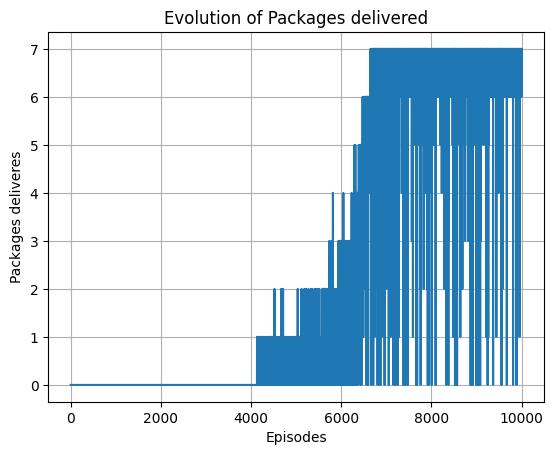

In [10]:
import matplotlib.pyplot as plt

plt.plot(entregas_historial)
plt.xlabel("Episodes")
plt.ylabel("Packages deliveres")
plt.title("Evolution of Packages delivered")
plt.grid(True)
plt.show()


In [11]:
# Calcular el promedio de puntos por episodio
promedio_puntos = sum(rewards_per_episode) / len(rewards_per_episode)

# Calcular el promedio de paquetes entregados por episodio
promedio_entregas = sum(entregas_historial) / len(entregas_historial)

# Mostrar los resultados
print(f"Promedio de puntos por episodio: {promedio_puntos:.2f}")
print(f"Promedio de paquetes entregados por episodio: {promedio_entregas:.2f}")


Promedio de puntos por episodio: 20.34
Promedio de paquetes entregados por episodio: 2.39


## Visualización con Animation

In [12]:
print( trayectoria_ultimo_ep)


[(1, 1), (2, 1), (2, 2), (3, 2), (4, 2), (4, 3), (5, 3), (6, 3), (7, 3), (8, 3), (8, 4), (9, 4), (9, 4), (9, 4), (9, 4), (9, 5), (9, 6), (8, 6), (8, 7), (8, 8), (8, 8), (9, 8), (9, 7), (9, 6), (9, 5), (9, 5), (9, 4), (9, 4), (9, 5), (8, 5), (8, 6), (8, 7), (8, 8), (8, 8), (8, 7), (8, 6), (9, 6), (9, 5), (9, 4), (9, 4), (9, 4), (9, 4), (9, 5), (9, 6), (9, 7), (8, 7), (8, 8), (8, 8), (8, 7), (8, 6), (8, 5), (9, 5), (9, 4), (9, 4), (9, 5), (8, 5), (8, 6), (8, 7), (8, 8), (8, 8), (8, 7), (8, 6), (8, 5), (9, 5), (9, 4), (9, 4), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 8), (8, 7), (9, 7), (9, 6), (9, 5), (9, 4), (9, 4), (9, 5), (8, 5), (8, 6), (8, 7), (8, 8), (8, 8), (8, 8), (8, 8), (8, 7), (9, 7), (9, 6), (9, 5), (9, 4), (9, 4), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 8), (8, 7), (8, 6), (8, 5)]


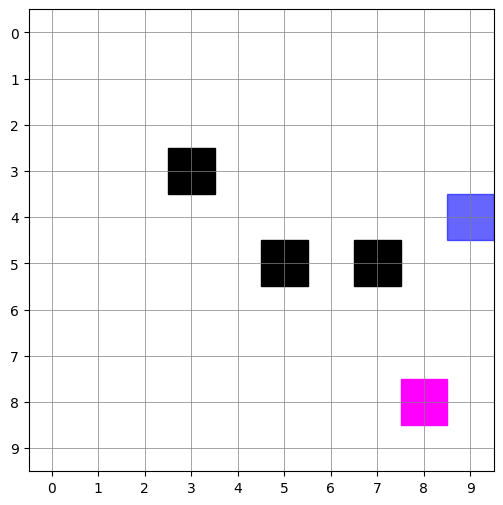

In [13]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import HTML  # Importante para mostrar la animación en Colab

# Verificar que la trayectoria se haya registrado correctamente
if not hasattr(env, "trayectoria_ultimo_ep") or len(env.trayectoria_ultimo_ep) == 0:
    raise ValueError("No se ha registrado la trayectoria del último episodio.")

trayectoria_ultimo_ep = env.trayectoria_ultimo_ep  # Lista de posiciones [(x, y)]
grid_size = env.grid_size  # Tamaño del grid

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(6, 6))  # Aumentar el tamaño para mayor claridad
ax.set_xlim(-0.5, grid_size - 0.5)
ax.set_ylim(grid_size - 0.5, -0.5)  # Se invierte el eje Y para que la cuadrícula se vea correctamente

# Mejorar la cuadrícula
ax.set_xticks(np.arange(0, grid_size, 1))
ax.set_yticks(np.arange(0, grid_size, 1))
ax.set_xticklabels(np.arange(0, grid_size, 1), fontsize=10, color='black')
ax.set_yticklabels(np.arange(0, grid_size, 1), fontsize=10, color='black')
ax.grid(which='both', color='gray', linestyle='-', linewidth=0.5)

# Dibujar obstáculos
for obs in env.obstacles:
    ax.add_patch(plt.Rectangle((obs[0] - 0.5, obs[1] - 0.5), 1, 1, color="black"))

# Dibujar el punto de recogida
pickup_x, pickup_y = env.pickup_point
ax.add_patch(plt.Rectangle((pickup_x - 0.5, pickup_y - 0.5), 1, 1, color="blue", alpha=0.6))

# Dibujar el punto de entrega
delivery_x, delivery_y = env.delivery_point
ax.add_patch(plt.Rectangle((delivery_x - 0.5, delivery_y - 0.5), 1, 1, color="magenta", alpha=1))

# Inicializar el robot en su primera posición
robot, = ax.plot([], [], "ro", markersize=10)  # "ro" = red circle (robot)

# Función para inicializar la animación
def init():
    robot.set_data([], [])
    return robot,

# Función para actualizar la animación
def update(frame):
    # Obtener las coordenadas del robot en el frame actual
    x, y = trayectoria_ultimo_ep[frame]

    # Imprimir las coordenadas de cada paso para verificar
    #print(f"Frame {frame}: Robot en ({x}, {y})")

    # Actualizar la posición del robot en la gráfica
    robot.set_data([x], [y])

    return robot,  # Devolver el objeto que se actualiza

# Crear la animación con intervalos de 1 segundo entre cada posición
ani = animation.FuncAnimation(fig, update, frames=len(trayectoria_ultimo_ep), init_func=init, interval=1000, repeat=False)

# Mostrar la animación en Google Colab
HTML(ani.to_jshtml())  # Esto permite que la animación se muestre en Google Colab
